In [1]:
import numpy as np
import tensorflow as tf
import gym
from gym import spaces
import copy

from stable_baselines.common.policies import *
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import *

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from celluloid import Camera

In [3]:
assert tf.version.VERSION[0] == '1'

## Area

In [4]:
class Area:
    def __init__(self, size=20, threshold=0.7, border_width=2, border_val=-3):
        self.size = size
        self.threshold = threshold
        self.border_width = border_width
        self.border_val = border_val
        self.area = self.__generate_area()

    def reset(self):
        self.area = self.__generate_area()
        
    def __generate_area(self):
        border_row = np.array([[self.border_val for i in range(self.size + 2*self.border_width)]])
        border = np.repeat(border_row, self.border_width, axis=0)
        init_area = border

        for i in range(self.size):
            row = (np.random.rand(self.size) > self.threshold).astype(int) * 3
            for i in range(self.border_width):
                row = np.insert(row, 0, self.border_val)
                row = np.append(row, self.border_val)
            init_area = np.concatenate((init_area, [row]))

        init_area = np.concatenate((init_area, border))

        return init_area

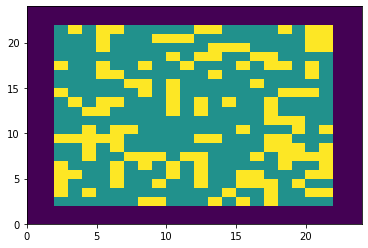

In [5]:
test_area = Area()

plt.pcolor(test_area.area)

## Agent

In [6]:
class Agent(gym.Env):
    
    def __init__(self, area):
        self.area = area
        self.reward_rangee = (0, 3)
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.MultiDiscrete(nvec=[3 for i in range(25)])
        
    def reset(self, train=True):
        self.fitness = 10
        self.position = (10, 10)
        self.reward_sum = 0
        if train:
            self.area.reset()
        
        return self._next_observation()
    
    def _next_observation(self):
        x, y = self.position
        visible = self.area.area[x-2:x+3, y-2:y+3]
        
        return visible.reshape(25)
    
    def step(self, action):
        
        reward = 0
        x, y = self.position
        
        if action < 4:
            if action == 0:
                new_y = y-1 if y>self.area.border_width else y
                self.position = x, new_y
            if action == 1: 
                new_y = y+1 if y<self.area.size + self.area.border_width - 1 else y
                self.position = x, new_y
            if action == 2:
                new_x = x+1 if x<self.area.size + self.area.border_width - 1 else x
                self.position = new_x, y
            if action == 3:
                new_x = x-1 if x>self.area.border_width else x
                self.position = new_x, y
            x, y = self.position
            self.fitness -= 1
        else:
            if self.area.area[x, y] == 3:
                self.reward_sum += 3
                self.fitness += 3
                reward = 3
                self.area.area[x, y] = 0
            else:
                self.fitness -= 1
        
        done = self.fitness <= 0
        
        obs = self._next_observation()
        
        return obs, reward, done, {}
    
    def render(self, mode='human', close=False):
        x, y = self.position
        print(self.reward_sum)
        return x, y

## Model

In [7]:
area = Area()
model = A2C(MlpPolicy, Agent(area), verbose=0)
model.learn(total_timesteps=30000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




## Simulation

In [11]:
area = Area()
env1 = Agent(area)
env2 = Agent(area)
env3 = Agent(area)
envs = [env1, env2, env3]
env_obs = {}

stored_maps = []

for env in envs:
    obs = env.reset(train=False)
    env_obs[env] = obs

for i in range(200):
    copied_map = np.copy(area.area)
    
    for env in envs:
        obs = env_obs[env]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        env_obs[env] = obs
        x, y = env.render()
        copied_map[x,y] = -2
        
    stored_maps.append(copied_map)

3
0
0
3
0
0
6
0
0
6
0
0
9
0
0
9
0
0
9
0
0
9
0
0
9
0
0
9
0
3
12
0
3
12
0
6
15
0
6
15
0
9
15
0
9
18
0
12
18
0
12
18
0
12
21
0
12
21
3
15
21
3
15
24
3
18
24
3
18
24
3
21
27
3
21
27
3
24
30
6
24
30
6
24
30
9
24
30
9
27
30
9
27
30
12
30
30
12
30
30
12
30
30
12
30
30
12
30
30
15
33
30
15
33
30
15
36
30
18
36
30
18
39
30
21
39
33
21
42
33
24
42
33
24
45
33
24
45
33
27
45
33
27
45
33
27
45
33
27
45
33
27
45
33
27
45
33
27
45
33
27
45
33
27
45
33
27
45
33
27
45
33
27
45
33
27
48
36
27
48
36
27
51
39
27
51
39
27
51
39
30
54
42
30
54
42
30
54
42
30
54
45
33
54
45
33
54
45
36
54
45
36
54
45
36
54
45
36
54
45
36
54
45
36
54
45
36
54
48
36
54
48
36
54
48
36
54
51
36
54
51
36
57
51
36
57
54
36
57
54
36
57
57
36
57
57
39
57
57
39
57
57
42
57
57
42
57
57
42
57
57
42
57
57
42
57
57
42
57
57
42
57
57
42
57
57
42
57
57
42
57
57
42
57
57
42
57
57
42
57
57
42
57
57
42
57
57
42
57
57
42
57
57
45
57
57
45
57
57
45
57
57
48
57
57
48
57
57
48
57
57
48
57
57
48
57
57
48
57
57
48
57
57
48
57
57
48
57
57
48
57
57


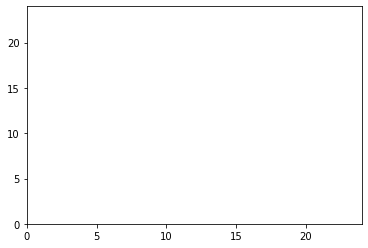

In [12]:
fig = plt.figure()
camera = Camera(fig)
for i in range(200):
    plt.pcolor(stored_maps[i])
    camera.snap()
animation = camera.animate()
animation.save('sim_final_3.gif', writer = 'imagemagick')